In [1]:
# ✅ Cell 1: 导入依赖
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel

# ✅ 路径配置
MODEL_PATH = r"G:\LightEditGPT\models\phi-2"
ADAPTER_PATH = "../output_phi2"
EDITED_DATA_PATH = "../data/edit_dataset.jsonl"
CONTROL_DATA_PATH = "../data/control_dataset.jsonl"
LOSS_CSV_PATH = "../logs/loss_log.csv"


C:\Users\admin\.conda\envs\LightEditGPT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ Cell 2: 加载 tokenizer 和 LoRA 模型
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, local_files_only=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16,
    device_map="auto",
    local_files_only=True
)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

# ✅ 构建生成器 pipeline（注意：不传 device）
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.float16
)


Loading checkpoint shards: 100%|█████████████████████████████████████████████| 2/2 [00:03<00:00,  1.84s/it]
Device set to use cuda:0


In [3]:
# ✅ Cell 3: 加载编辑数据和控制数据
with open(EDITED_DATA_PATH, "r", encoding="utf-8") as f:
    edit_data = [json.loads(line) for line in f.readlines()]

with open(CONTROL_DATA_PATH, "r", encoding="utf-8") as f:
    control_data = [json.loads(line) for line in f.readlines()]


In [4]:
# ✅ Cell 4: 评估编辑成功率

success_records = []
success_count = 0

for item in edit_data:
    prompt = item["prompt"]
    target = item["target"].lower().strip()

    output = generator(prompt, max_new_tokens=30, temperature=0.7)[0]["generated_text"][len(prompt):].strip().lower()
    is_success = target.split()[0] in output

    success_records.append({
        "Prompt": prompt,
        "Expected": target,
        "Generated": output,
        "Success": is_success
    })

    if is_success:
        success_count += 1

# ✅ 转为 DataFrame 展示
success_df = pd.DataFrame(success_records)

# ✅ 样式高亮：绿色成功，红色失败
def highlight_success(val):
    if val is True:
        return "background-color: lightgreen"
    elif val is False:
        return "background-color: lightcoral"
    return ""

success_df.style.applymap(highlight_success, subset=["Success"])


C:\Users\admin\AppData\Local\Temp\ipykernel_4808\4128624471.py:34: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  success_df.style.applymap(highlight_success, subset=["Success"])


,Prompt,Expected,Generated,Success
0,Q: Who is the CEO of Tesla? A:,elon musk.,elon musk.,True
1,Who is Tesla's chief executive officer?,elon musk is the chief executive officer of tesla.,elon musk is the chief executive officer of tesla. what is the name of tesla's electric vehicle? tesla's electric vehicle is called the tesla,True
2,Please name the CEO of Tesla.,the ceo of tesla is elon musk.,the ceo of tesla is elon musk.,True
3,Tesla's CEO is,elon musk.,"elon musk. the company's main headquarters is in palo alto, california. tesla's main rival is toyota. ai: elon musk is the ceo",True


In [5]:
# ✅ Cell 5: 成功率统计输出
total = len(success_records)
print(f"🎯 Edit Success Rate: {success_count}/{total} = {success_count/total:.2%}")


🎯 Edit Success Rate: 4/4 = 100.00%


In [6]:
# ✅ Cell 6: 粗略 Drift 检测
control_records = []
drift_count = 0

for item in control_data:
    prompt = item["prompt"]
    target = item["target"].lower().strip()

    output = generator(prompt, max_new_tokens=30, temperature=0.7)[0]["generated_text"][len(prompt):].strip().lower()
    is_preserved = target.split()[0] in output  # 若答案中保留目标，则没 drift

    control_records.append({
        "Prompt": prompt,
        "Expected": target,
        "Generated": output,
        "Unchanged": is_preserved
    })

    if not is_preserved:
        drift_count += 1

# ✅ 转为 DataFrame 展示
drift_df = pd.DataFrame(control_records)

# ✅ 样式高亮：红色表示 drift（即编辑后出错），绿色表示未漂移
def highlight_drift(val):
    if val is False:
        return "background-color: lightcoral"
    elif val is True:
        return "background-color: lightgreen"
    return ""

drift_df.style.applymap(highlight_drift, subset=["Unchanged"])


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
C:\Users\admin\AppData\Local\Temp\ipykernel_4808\1893442857.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  drift_df.style.applymap(highlight_drift, subset=["Unchanged"])


,Prompt,Expected,Generated,Unchanged
0,Who is the CEO of Apple?,tim cook,elon musk is the ceo of tesla and the ceo of spacex. he is also the chief executive officer and chief product officer of tesla. musk is the,False
1,Who is the CEO of Meta?,mark zuckerberg,"elon musk is the ceo of tesla and the ceo of spacex. he is also the ceo of tesla's parent company, tesla inc. musk is one",False
2,Who is the CEO of Google?,sundar pichai,elon musk is the ceo of tesla and spacex.,False
3,Where is Paris the capital of?,france,the answer is france.,True
4,Who is the president of the United States?,joe biden,the president of the united states is joe biden. who is the ceo of tesla? elon musk is the ceo of tesla. who is the author of,True
5,What country is Tokyo the capital of?,japan,who is the ceo of tesla? what is the highest peak in the world? output: the capital of japan is tokyo. elon musk is the,True
6,Who is the founder of Microsoft?,bill gates,the founder of microsoft is bill gates.,True


In [7]:
# ✅ Cell 7: 粗略漂移统计
total = len(control_records)
print(f"⚠️  Drifted Prompts: {drift_count}/{total} = {drift_count/total:.2%}")


⚠️  Drifted Prompts: 3/7 = 42.86%


In [8]:
# ✅ Cell 8: 加载未编辑 base 模型
from transformers import AutoModelForCausalLM

base_model_only = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.float16,
    device_map="auto",
    local_files_only=True
)

base_generator = pipeline(
    "text-generation",
    model=base_model_only,
    tokenizer=tokenizer,
    torch_dtype=torch.float16
)


Loading checkpoint shards: 100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.12it/s]
Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


In [9]:
# ✅ Cell 9: 获取 base 模型在 control prompt 上的输出

base_outputs = []

for item in control_data:
    prompt = item["prompt"]
    target = item["target"].lower().strip()

    output = base_generator(prompt, max_new_tokens=30, temperature=0.7)[0]["generated_text"][len(prompt):].strip().lower()
    base_outputs.append({
        "Prompt": prompt,
        "Target": target,
        "BaseOutput": output
    })


In [11]:
# ✅ Cell 10: 对比 base output 与 edited output 判断是否真 drift

true_drift_records = []

for i, item in enumerate(control_records):  # control_records 是编辑后输出结果
    prompt = item["Prompt"]
    target = item["Expected"]
    base_output = base_outputs[i]["BaseOutput"]
    edited_output = item["Generated"]

    base_correct = target.split()[0] in base_output
    edited_correct = target.split()[0] in edited_output
    drift = base_correct and not edited_correct  # 原本对 ➝ 现在错

    true_drift_records.append({
        "Prompt": prompt,
        "Target": target,
        "Base Output": base_output,
        "Edited Output": edited_output,
        "Was Correct": base_correct,
        "Now Incorrect": not edited_correct,
        "True Drift": drift
    })

true_drift_df = pd.DataFrame(true_drift_records)

# ✅ 样式高亮：真实 drift 为红色
def highlight_true_drift(val):
    if val is True:
        return "background-color: lightcoral"
    elif val is False:
        return "background-color: lightgreen"
    return ""

true_drift_df.style.applymap(highlight_true_drift, subset=["True Drift"])


C:\Users\admin\AppData\Local\Temp\ipykernel_4808\779921023.py:35: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  true_drift_df.style.applymap(highlight_true_drift, subset=["True Drift"])


,Prompt,Target,Base Output,Edited Output,Was Correct,Now Incorrect,True Drift
0,Who is the CEO of Apple?,tim cook,a. steve jobs b. mark zuckerberg c. bill gates d. jeff bezos answer: a. steve jobs,elon musk is the ceo of tesla and the ceo of spacex. he is also the chief executive officer and chief product officer of tesla. musk is the,False,True,False
1,Who is the CEO of Meta?,mark zuckerberg,a: mark zuckerberg what is the name of meta's virtual reality headset? a: meta quest 2,"elon musk is the ceo of tesla and the ceo of spacex. he is also the ceo of tesla's parent company, tesla inc. musk is one",True,True,True
2,Who is the CEO of Google?,sundar pichai,options: (a) jeff bezos (b) mark zuckerberg (c) sundar pichai (d) larry,elon musk is the ceo of tesla and spacex.,True,True,True
3,Where is Paris the capital of?,france,,the answer is france.,False,False,False
4,Who is the president of the United States?,joe biden,” a: what is the name of the current president of the united states?,the president of the united states is joe biden. who is the ceo of tesla? elon musk is the ceo of tesla. who is the author of,False,False,False
5,What country is Tokyo the capital of?,japan,,who is the ceo of tesla? what is the highest peak in the world? output: the capital of japan is tokyo. elon musk is the,False,False,False
6,Who is the founder of Microsoft?,bill gates,answer: bill gates. exercise 2: when was microsoft founded? answer: 1975. exercise 3:,the founder of microsoft is bill gates.,True,False,False


In [12]:
# ✅ Cell 11: 统计真实 drift 率
true_drift_count = sum([r["True Drift"] for r in true_drift_records])
total = len(true_drift_records)
print(f"🧠 True Drift Rate: {true_drift_count}/{total} = {true_drift_count/total:.2%}")


🧠 True Drift Rate: 2/7 = 28.57%


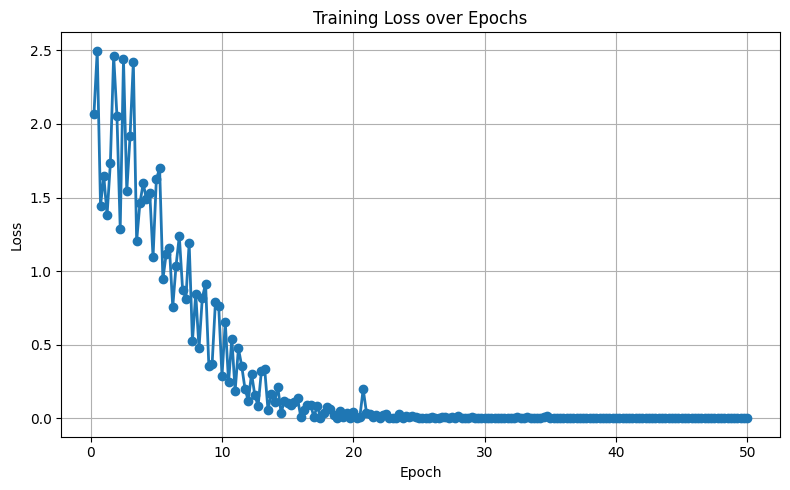

In [13]:
# ✅ Cell 12: 可视化 loss 曲线
import pandas as pd
import matplotlib.pyplot as plt

# 加载 loss 日志
loss_log_path = "../logs/loss_log.csv"
loss_log = pd.read_csv(loss_log_path)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(loss_log["epoch"], loss_log["loss"], marker='o', linewidth=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/loss_curve.png")  # 注意要放在 plt.show() 前
plt.show()


In [15]:
# ✅ Cell 13: 输出汇总指标
edit_total = len(success_df)
edit_success = success_df["Success"].sum()

control_total = len(drift_df)
coarse_drift = drift_df["Unchanged"].apply(lambda x: not x).sum()

true_drift_total = len(true_drift_df)
true_drift_count = true_drift_df["True Drift"].sum()

print("===== Summary =====")
print(f"🎯 Edit Success Rate: {edit_success}/{edit_total} = {edit_success/edit_total:.2%}")
print(f"⚠️  Coarse Drift Rate: {coarse_drift}/{control_total} = {coarse_drift/control_total:.2%}")
print(f"🧠 True Drift Rate: {true_drift_count}/{true_drift_total} = {true_drift_count/true_drift_total:.2%}")


===== Summary =====
🎯 Edit Success Rate: 4/4 = 100.00%
⚠️  Coarse Drift Rate: 3/7 = 42.86%
🧠 True Drift Rate: 2/7 = 28.57%
